# Interpolation to $\sigma_p$ levels test using the UM output.

In [1]:
from functools import partial

import iris
import matplotlib.pyplot as plt
import netCDF4  # just to check the version
import numpy as np
from iris.experimental import stratify

In [2]:
import aeolus
from aeolus.calc import sigma_p, spatial_mean, time_mean
from aeolus.const import init_const
from aeolus.core import AtmoSim
from aeolus.model import um

In [3]:
import paths
import pouch
import quickplot as qplt
from pouch.clim_diag import calc_derived_cubes, last_n_day_mean

In [4]:
plt.style.use("custom.mplstyle")
pouch.RUNTIME.figsave_stamp = False

In [5]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-11-15T14:34:50.885605+00:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.6.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

aeolus    : 0.4.15+14.g02f78ce
matplotlib: 3.6.2
iris      : 3.3.0
netCDF4   : 1.6.0
pouch     : 0.0.dev0
numpy     : 1.23.4



In [6]:
def load_proc_um_data(sim_label):
    fnames = sorted((paths.results_proc_um / sim_label).glob(f"{sim_label}*.nc"))
    with iris.FUTURE.context(datum_support=True):
        dset = iris.load(fnames)
    return dset

In [7]:
SIM_CASES = {
    "hs": {
        "title": "Held-Suarez",
        "short_title": "HS-IP",
        "planet": "earth",
        "kw_plt": {"color": "C0"},
        "timestep": 1200,
    },
    "hs2": {
        "title": "Held-Suarez Dynamical",
        "short_title": "HS-DC",
        "planet": "earth",
        "kw_plt": {"color": "C3"},
        "timestep": 1200,
    },
    "el": {
        "title": "Earth-like",
        "short_title": "EL",
        "planet": "earth",
        "kw_plt": {"color": "C1"},
        "timestep": 1200,
    },
    "tle": {
        "title": "Tidally Locked Earth",
        "short_title": "TLE",
        "planet": "earth",
        "kw_plt": {"color": "C2"},
        "timestep": 1200,
    },
}

MODELS = {
    "um": {
        "title": "UM",
        "get_files": load_proc_um_data,
        "kw_plt": {"linestyle": "--", "linewidth": 0.75, "dash_capstyle": "round"},
    },
}

In [8]:
# height_theta, height_rho = the_run.extract("height_above_reference_ellipsoid")
height_theta = np.linspace(0, 32000, 33)
height_rho = np.linspace(1000, 32000, 32) - 500

In [9]:
runs = {}
for model_key, model_prop in MODELS.items():
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        cl = model_prop["get_files"](sim_label)
        const = init_const(sim_prop["planet"])
        calc_derived_cubes(cl, const=const)
        runs[model_key][sim_label] = AtmoSim(
            cl,
            name=sim_label,
            vert_coord="z",
            planet=sim_prop["planet"],
            const_dir=paths.const,
        )
        np.testing.assert_allclose(
            height_theta, runs[model_key][sim_label].coord.z.points
        )

## Zonal mean cross-sections

In [10]:
sim_label = "hs"

In [11]:
the_run = runs[model_key][sim_label]

Create a callable to pass to the interpolation routine. Use linear extrapolation.

In [12]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Create an array of sigma levels, using the table A1 in Mayne et al. (2014).

In [13]:
# sigma_levels = np.array(
#     [
#         1.0,
#         0.975,  # additional level for horiz. sections
#         0.97,
#         0.94,
#         0.91,
#         0.88,
#         0.84,
#         0.81,
#         0.78,
#         0.75,
#         0.72,
#         0.69,
#         0.66,
#         0.63,
#         0.6,
#         0.57,
#         0.53,
#         0.525,  # additional level for horiz. sections
#         0.5,
#         0.47,
#         0.44,
#         0.41,
#         0.38,
#         0.35,
#         0.32,
#         0.28,
#         0.26,
#         0.225,  # additional level for horiz. sections
#         0.22,
#         0.19,
#         0.16,
#         0.13,
#         0.1,
#         0.07,
#         0.04,
#         0.01,
#     ]
# )
sigma_levels = np.linspace(1, 0.01, 34)

Test the interpolation using the cube of height

In [14]:
gpot_height = cl.extract_cube("geopotential_height")

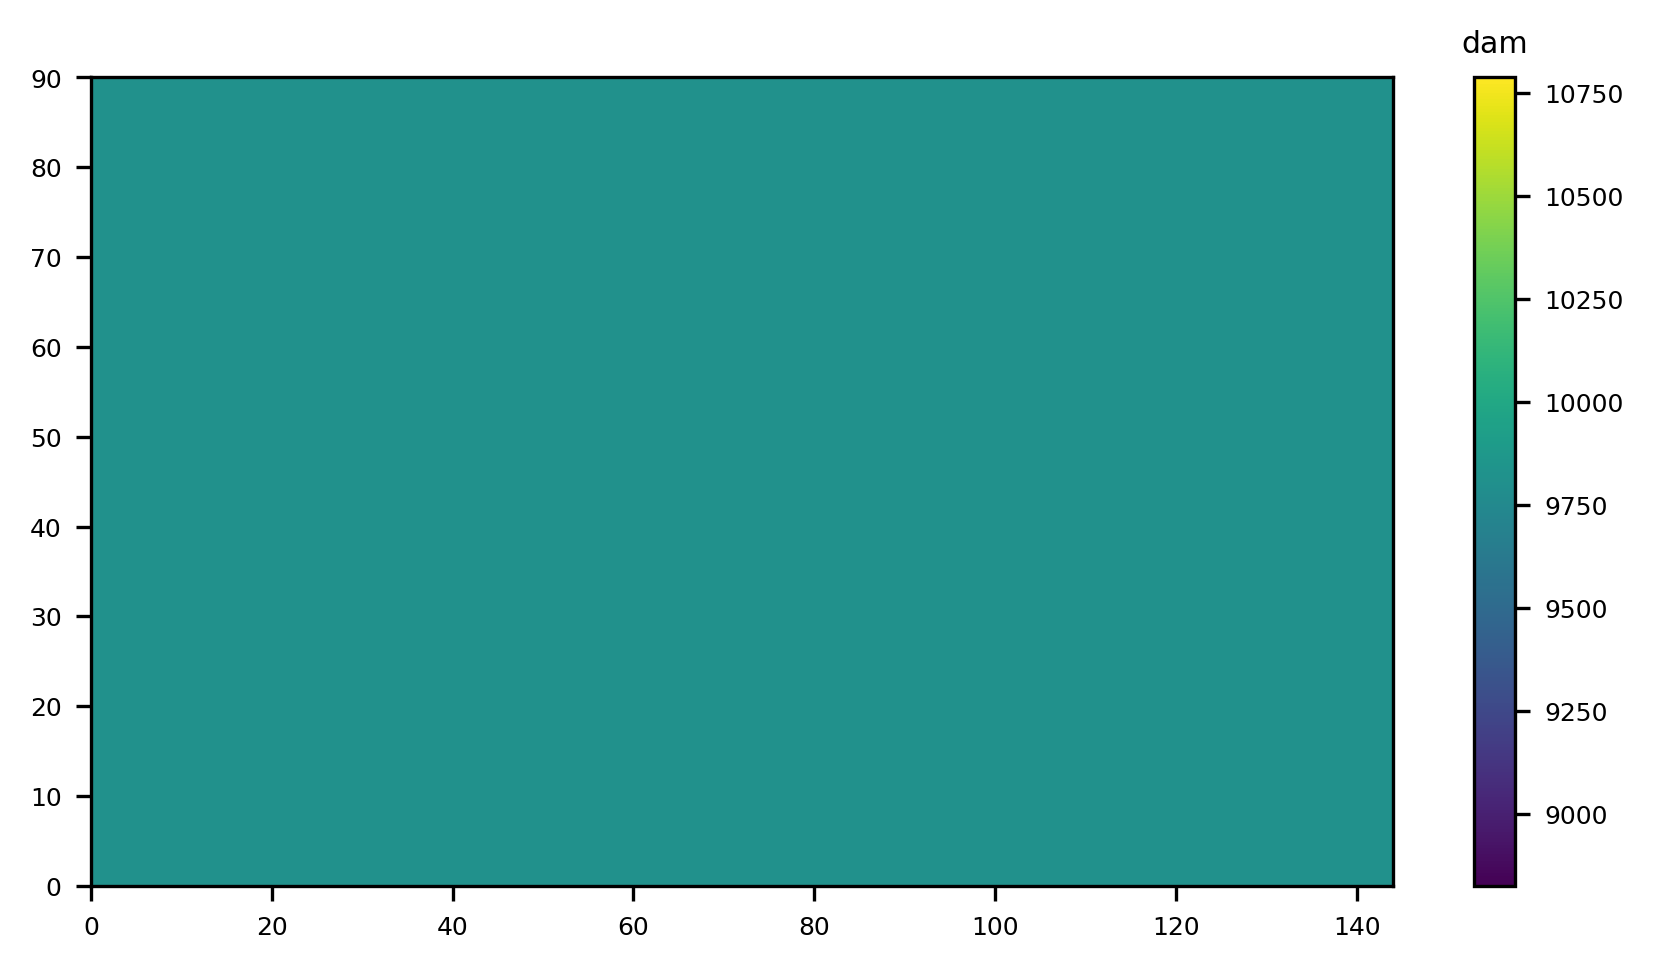

In [15]:
plt.pcolormesh(gpot_height[-1, 1, ...].data)
cbar = plt.colorbar()
cbar.ax.set_title("dam");

In [16]:
gpot_height_slev = stratify.relevel(
    gpot_height[-1, ...],
    the_run.sigma_p[-1, ...],
    sigma_levels,
    axis=um.z,
    interpolator=INTERPOLATOR,
)

Text(0.5, 1.0, '(test) p=0.97')

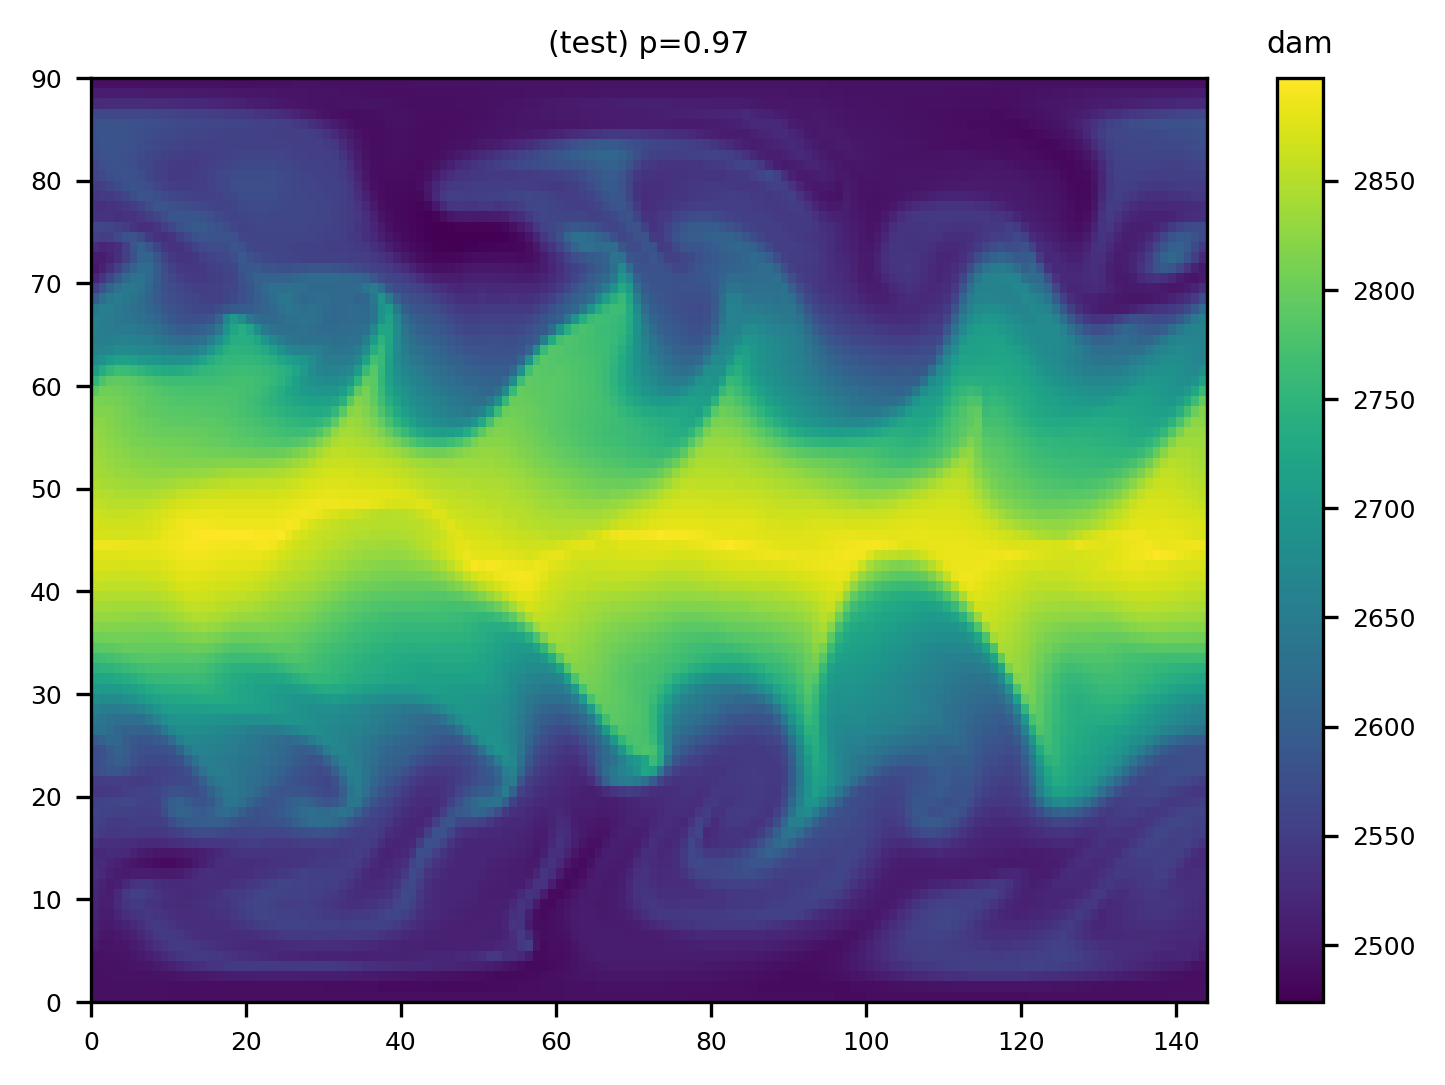

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
p0 = ax.pcolormesh(gpot_height_slev[1, ...].data)
cbar = fig.colorbar(p0)
cbar.ax.set_title("dam")
ax.set_title(
    f"(test) p={gpot_height_slev[1, ...].coord('atmosphere_hybrid_sigma_pressure_coordinate').points[0]}"
)

In [18]:
gpot_height_slev_gm = spatial_mean(gpot_height_slev, model=um)
normalised_height = gpot_height_slev_gm.data / gpot_height_slev_gm.data.max()

Compare with Table A1 in Mayne et al. (2014).

In [19]:
[*zip(np.round(sigma_levels, decimals=2), np.round(normalised_height, decimals=6))]

[(1.0, 0.0),
 (0.97, 0.009282),
 (0.94, 0.018565),
 (0.91, 0.027847),
 (0.88, 0.037487),
 (0.85, 0.047775),
 (0.82, 0.058064),
 (0.79, 0.068532),
 (0.76, 0.079747),
 (0.73, 0.091072),
 (0.7, 0.102652),
 (0.67, 0.114935),
 (0.64, 0.127388),
 (0.61, 0.140395),
 (0.58, 0.153996),
 (0.55, 0.167954),
 (0.52, 0.182666),
 (0.49, 0.197902),
 (0.46, 0.213995),
 (0.43, 0.230776),
 (0.4, 0.248594),
 (0.37, 0.267362),
 (0.34, 0.287304),
 (0.31, 0.308779),
 (0.28, 0.331662),
 (0.25, 0.356599),
 (0.22, 0.384212),
 (0.19, 0.414967),
 (0.16, 0.450045),
 (0.13, 0.491409),
 (0.1, 0.543356),
 (0.07, 0.613613),
 (0.04, 0.724338),
 (0.01, 1.0)]